In [1]:
# Standard libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import pandas as pd
import json
from pathlib import Path

# Deep learning libraries
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

# Evaluation tools
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# Reproducibility
seed=42
np.random.seed(seed)
random.seed(seed)

In [3]:
# Define base project directory
PROJECT_DIR=Path.cwd()

# Data directory (raw and processed)
DATA_DIR=PROJECT_DIR/'data'
RAW_DATA_DIR = DATA_DIR / "raw"
PROCESSED_DATA_DIR = DATA_DIR / "processed"

# Directory for trained models
MODEL_DIR=PROJECT_DIR/'models'

# Directory for plots, logs and other artifacts
ARTIFACTS_DIR=PROJECT_DIR/'artifacts'

# Create directories if they don't exist
for dir in [RAW_DATA_DIR, PROCESSED_DATA_DIR, MODEL_DIR, ARTIFACTS_DIR]:
  dir.mkdir(parents=True, exist_ok=True)

print('Folders ready')

Folders ready


In [4]:
# Model parameters
param={
  'img_height':28,
  'img_width':28,
  'batch_size':64,
  'channels':1,
  'num_classes':10,
  'epochs':12,
  'validation_split':0.1,
  'learning_rate':1e-3,
}

In [5]:
# Load the data and split it into training and test sets
(X_train, y_train), (X_test, y_test)=mnist.load_data()

In [6]:
# Save raw data
np.save(RAW_DATA_DIR/'X_train_raw.npy', X_train)
np.save(RAW_DATA_DIR/'y_train_raw.npy', y_train)
np.save(RAW_DATA_DIR/'X_test_raw.npy', X_test)
np.save(RAW_DATA_DIR/'y_test_raw.npy', y_test)
print('Raw data saved')

Raw data saved


In [7]:
# Check dataset structure
print(f'Training data shape: {X_train.shape}, Labels shape: {y_train.shape}')
print(f'Test data shape: {X_test.shape}, Labels shape: {y_test.shape}')
print(f'Unique labels {np.unique(y_train)}')

Training data shape: (60000, 28, 28), Labels shape: (60000,)
Test data shape: (10000, 28, 28), Labels shape: (10000,)
Unique labels [0 1 2 3 4 5 6 7 8 9]


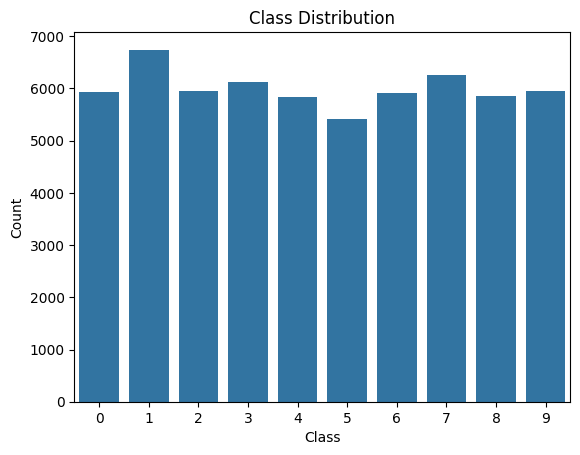

Class distribution saved to /content/artifacts/class_distribution.png


In [8]:
# Visualize class distribution
unique, counts=np.unique(y_train, return_counts=True)
sns.barplot(x=unique, y=counts)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
save_path=ARTIFACTS_DIR/'class_distribution.png'
plt.savefig(save_path, dpi=300)
plt.show()
print(f"Class distribution saved to {save_path}")

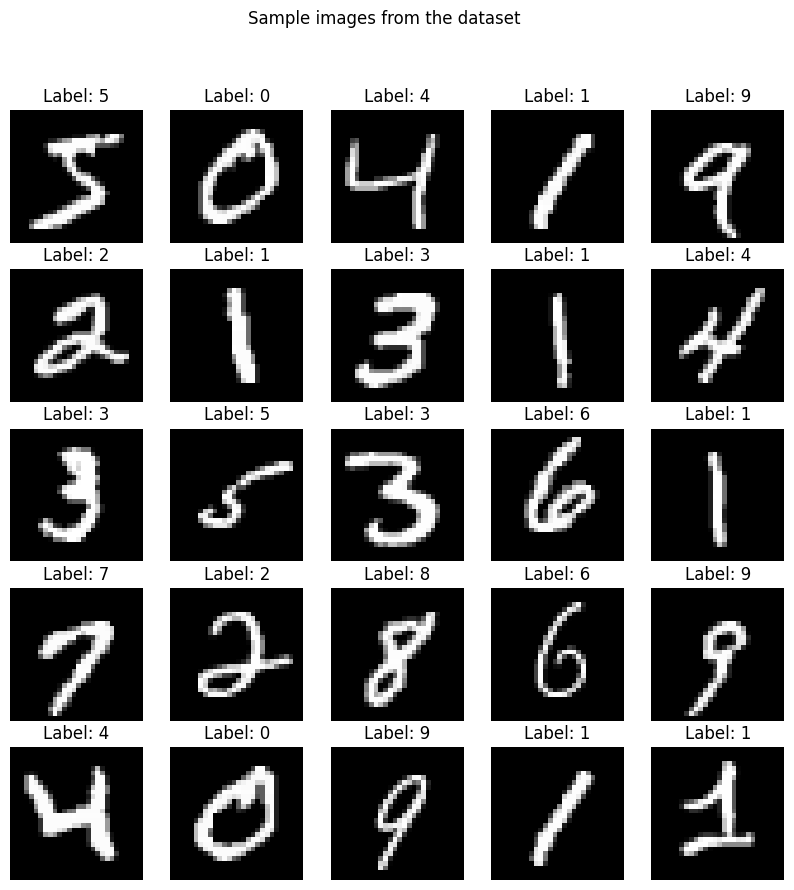

Sample images saved to /content/artifacts/sample_images.png


In [9]:
# Show sample images
plt.figure(figsize=(10, 10))
for i in range(25):
  plt.subplot(5, 5, i+1)
  plt.imshow(X_train[i], cmap='gray')
  plt.title(f"Label: {y_train[i]}")
  plt.axis('off')
plt.suptitle('Sample images from the dataset')
save_path=ARTIFACTS_DIR/'sample_images.png'
plt.savefig(save_path, dpi=300)
plt.show()
print(f"Sample images saved to {save_path}")

Preprocess the Data

In [10]:
# Normalize pixel values to be between 0 and 1
X_train=X_train.astype('float32')/255.0
X_test=X_test.astype('float32')/255.0

# Reshape the data to add a channel dimension (for grayscale)
X_train=X_train.reshape(-1, param['img_height'], param['img_width'], param['channels'])
X_test=X_test.reshape(-1, param['img_height'], param['img_width'], param['channels'])

# Print the new shape of the data to verify
print(f'Training data shape after reshaping: {X_train.shape}')
print(f'Test data shape after reshaping: {X_test.shape}')

Training data shape after reshaping: (60000, 28, 28, 1)
Test data shape after reshaping: (10000, 28, 28, 1)


One-Hot Encode the Labels

In [11]:
# Convert labels to categorical
y_train=to_categorical(y_train, param['num_classes'])
y_test=to_categorical(y_test, param['num_classes'])

In [12]:
# Save processed data
np.save(PROCESSED_DATA_DIR/'X_train.npy', X_train)
np.save(PROCESSED_DATA_DIR/'y_train.npy', y_train)
np.save(PROCESSED_DATA_DIR/'X_test.npy', X_test)
np.save(PROCESSED_DATA_DIR/'y_test.npy', y_test)
print('Processed data saved')

Processed data saved


In [13]:
# Data augmentation
datagen=ImageDataGenerator(
  rotation_range=12,
  width_shift_range=0.08,
  height_shift_range=0.08,
  zoom_range=0.08,
  shear_range=0.06,
  validation_split=param['validation_split']
)

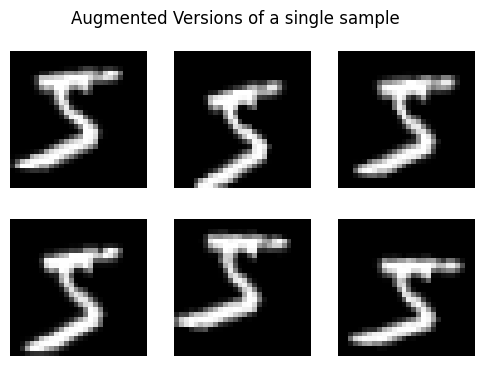

Augmented images saved to /content/artifacts/augmented_sample.png


In [14]:
# Show augmented images
sample_idx=0
sample_image=X_train[sample_idx]
sample_batch=np.expand_dims(sample_image, axis=0)
iterator=datagen.flow(sample_batch, batch_size=1)
plt.figure(figsize=(6, 4))
for i in range(6):
  augmented_image=next(iterator)[0]
  plt.subplot(2, 3, i+1)
  plt.imshow(augmented_image.squeeze(), cmap='gray')
  plt.axis('off')
plt.suptitle('Augmented Versions of a single sample')
save_path=ARTIFACTS_DIR/'augmented_sample.png'
plt.savefig(save_path, dpi=300)
plt.show()
print(f"Augmented images saved to {save_path}")

Build the CNN Model

In [15]:
# Initialize the model
def build_cnn_model(input_shape, num_classes):
  model=Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-4), input_shape=input_shape),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-4)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-4)),
    BatchNormalization(),

    Flatten(),

    Dense(128, activation='relu'),
    Dropout(0.4),

    Dense(num_classes, activation='softmax')
  ])

  return model

model=build_cnn_model((param['img_height'], param['img_width'], param['channels']), param['num_classes'])

# Compile the model
model.compile(optimizer=Adam(learning_rate=param['learning_rate']), loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       802,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 897,802 (3.42 MB)

 Trainable params: 897,354 (3.42 MB)

 Non-trainable params: 448 (1.75 KB)

In [16]:
# Training setup
checkpoint_path=MODEL_DIR/'best_model.h5'

cb=[
  EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True),
  ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
  ModelCheckpoint(checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True)
]

train_gen=datagen.flow(X_train, y_train, batch_size=param['batch_size'], subset='training', seed=seed)
val_gen=datagen.flow(X_train, y_train, batch_size=param['batch_size'], subset='validation', seed=seed)

steps_per_epoch=len(train_gen)
validation_steps=len(val_gen)

Train the Model

In [17]:
# Train the model
history=model.fit(
  train_gen,
  validation_data=val_gen,
  epochs=param['epochs'],
  callbacks=cb,
  steps_per_epoch=steps_per_epoch,
  validation_steps=validation_steps
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/12
844/844 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.8517 - loss: 0.5055
Epoch 1: val_accuracy improved from -inf to 0.96283, saving model to /content/models/best_model.h5


844/844 ━━━━━━━━━━━━━━━━━━━━ 142s 164ms/step - accuracy: 0.8518 - loss: 0.5053 - val_accuracy: 0.9628 - val_loss: 0.1566 - learning_rate: 0.0010
Epoch 2/12
844/844 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.9665 - loss: 0.1334
Epoch 2: val_accuracy improved from 0.96283 to 0.98233, saving model to /content/models/best_model.h5


844/844 ━━━━━━━━━━━━━━━━━━━━ 142s 164ms/step - accuracy: 0.9665 - loss: 0.1334 - val_accuracy: 0.9823 - val_loss: 0.0834 - learning_rate: 0.0010
Epoch 3/12
844/844 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.9771 - loss: 0.1021
Epoch 3: val_accuracy improved from 0.98233 to 0.98283, saving model to /content/models/best_model.h5


844/844 ━━━━━━━━━━━━━━━━━━━━ 145s 167ms/step - accuracy: 0.9771 - loss: 0.1021 - val_accuracy: 0.9828 - val_loss: 0.0801 - learning_rate: 0.0010
Epoch 4/12
844/844 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9801 - loss: 0.0909
Epoch 4: val_accuracy did not improve from 0.98283
844/844 ━━━━━━━━━━━━━━━━━━━━ 138s 163ms/step - accuracy: 0.9801 - loss: 0.0909 - val_accuracy: 0.9817 - val_loss: 0.1001 - learning_rate: 0.0010
Epoch 5/12
844/844 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9816 - loss: 0.0892
Epoch 5: val_accuracy improved from 0.98283 to 0.99067, saving model to /content/models/best_model.h5


844/844 ━━━━━━━━━━━━━━━━━━━━ 142s 163ms/step - accuracy: 0.9816 - loss: 0.0892 - val_accuracy: 0.9907 - val_loss: 0.0613 - learning_rate: 0.0010
Epoch 6/12
844/844 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9847 - loss: 0.0804
Epoch 6: val_accuracy did not improve from 0.99067
844/844 ━━━━━━━━━━━━━━━━━━━━ 138s 164ms/step - accuracy: 0.9847 - loss: 0.0805 - val_accuracy: 0.9868 - val_loss: 0.0720 - learning_rate: 0.0010
Epoch 7/12
844/844 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.9853 - loss: 0.0774
Epoch 7: val_accuracy did not improve from 0.99067
844/844 ━━━━━━━━━━━━━━━━━━━━ 141s 162ms/step - accuracy: 0.9853 - loss: 0.0774 - val_accuracy: 0.9833 - val_loss: 0.0850 - learning_rate: 0.0010
Epoch 8/12
844/844 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.9856 - loss: 0.0814
Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 8: val_accuracy did not improve from 0.99067
844/844 ━━━━━━━━━━━━━━━━━━━━ 143s 169ms/step - accuracy: 0.9856 - loss:

844/844 ━━━━━━━━━━━━━━━━━━━━ 198s 164ms/step - accuracy: 0.9881 - loss: 0.0698 - val_accuracy: 0.9917 - val_loss: 0.0584 - learning_rate: 5.0000e-04
Epoch 10/12
844/844 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9916 - loss: 0.0570
Epoch 10: val_accuracy improved from 0.99167 to 0.99183, saving model to /content/models/best_model.h5


844/844 ━━━━━━━━━━━━━━━━━━━━ 142s 164ms/step - accuracy: 0.9916 - loss: 0.0570 - val_accuracy: 0.9918 - val_loss: 0.0603 - learning_rate: 5.0000e-04
Epoch 11/12
844/844 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9911 - loss: 0.0587
Epoch 11: val_accuracy improved from 0.99183 to 0.99300, saving model to /content/models/best_model.h5


844/844 ━━━━━━━━━━━━━━━━━━━━ 142s 164ms/step - accuracy: 0.9911 - loss: 0.0587 - val_accuracy: 0.9930 - val_loss: 0.0490 - learning_rate: 5.0000e-04
Epoch 12/12
844/844 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.9915 - loss: 0.0555
Epoch 12: val_accuracy did not improve from 0.99300
844/844 ━━━━━━━━━━━━━━━━━━━━ 138s 164ms/step - accuracy: 0.9915 - loss: 0.0555 - val_accuracy: 0.9923 - val_loss: 0.0510 - learning_rate: 5.0000e-04
Restoring model weights from the end of the best epoch: 11.


Evaluate the Model

In [18]:
# Load the model
loaded_model=load_model(checkpoint_path)

In [19]:
# Evaluate the model on test set
val_loss, val_acc=loaded_model.evaluate(X_test, y_test)
print(f"Validation Accuracy: {val_acc*100:.2f}%")
print(f"Validation Loss: {val_loss:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.9919 - loss: 0.0526
Validation Accuracy: 99.30%
Validation Loss: 0.0482


Training history saved to /content/artifacts/training_history.png


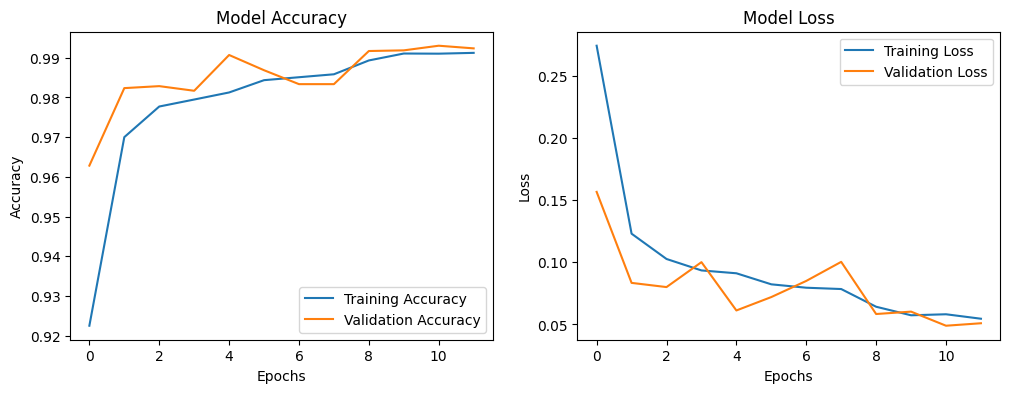

In [20]:
# Plot training and validation accuracy values
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

save_path=ARTIFACTS_DIR/'training_history.png'
plt.savefig(save_path, dpi=300)
print(f"Training history saved to {save_path}")

# Show plots
plt.show()

In [21]:
# Save training history
history_path=ARTIFACTS_DIR/'history.json'
with open(history_path, 'w') as f:
  json.dump(history.history, f)
print(f"History saved to {history_path}")

History saved to /content/artifacts/history.json


313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step


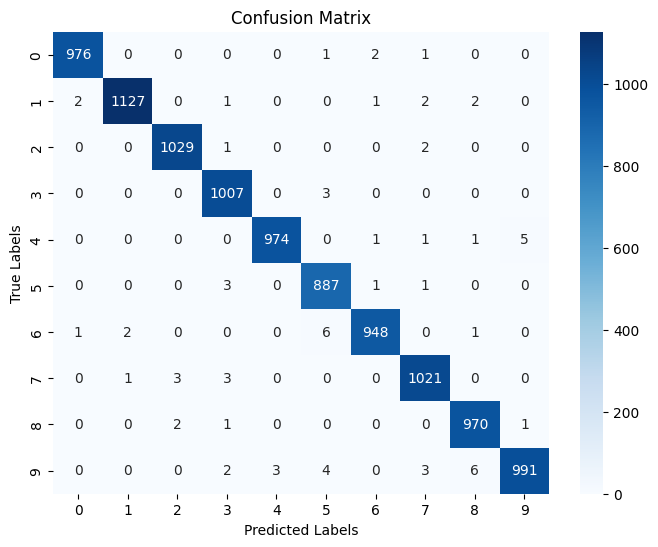

In [22]:
# Prediction and metrics
y_pred=np.argmax(loaded_model.predict(X_test), axis=1)
y_true=np.argmax(y_test, axis=1)

# Confusion matrix
cm=confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
save_path=ARTIFACTS_DIR/'confusion_matrix.png'
plt.savefig(save_path, dpi=300)
plt.show()

In [23]:
# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       980
           1       1.00      0.99      1.00      1135
           2       1.00      1.00      1.00      1032
           3       0.99      1.00      0.99      1010
           4       1.00      0.99      0.99       982
           5       0.98      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.99      1.00      0.99       974
           9       0.99      0.98      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



In [24]:
# Per-class accuracy
class_accuracy=np.diag(cm) / np.sum(cm, axis=1)
df_accuracy=pd.DataFrame({'Class': range(10), 'Accuracy': class_accuracy})
df_accuracy

,Class,Accuracy
0,0,0.995918
1,1,0.992952
2,2,0.997093
3,3,0.997030
4,4,0.991853
5,5,0.994395
6,6,0.989562
7,7,0.993191
8,8,0.995893
9,9,0.982161


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


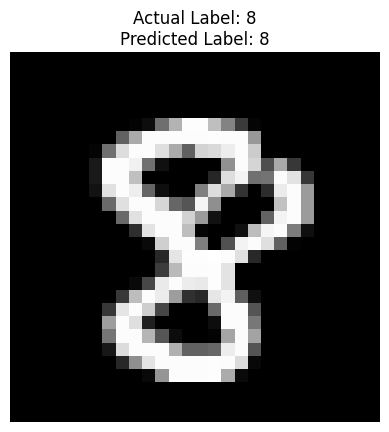

In [25]:
# Choose a test image at random
index=np.random.randint(0, X_test.shape[0])
image=X_test[index]
label=np.argmax(y_test[index])

# Add a batch dimension and make a prediction
prediction=loaded_model.predict(image.reshape(1, 28, 28, 1))
predicted_label=np.argmax(prediction)

# Display the result
plt.imshow(image.reshape(28, 28), cmap='gray')
plt.title(f"Actual Label: {label}\nPredicted Label: {predicted_label}")
plt.axis('off')
save_path=ARTIFACTS_DIR/'prediction_result.png'
plt.savefig(save_path, dpi=300)
plt.show()

Number of misclassified examples: 70


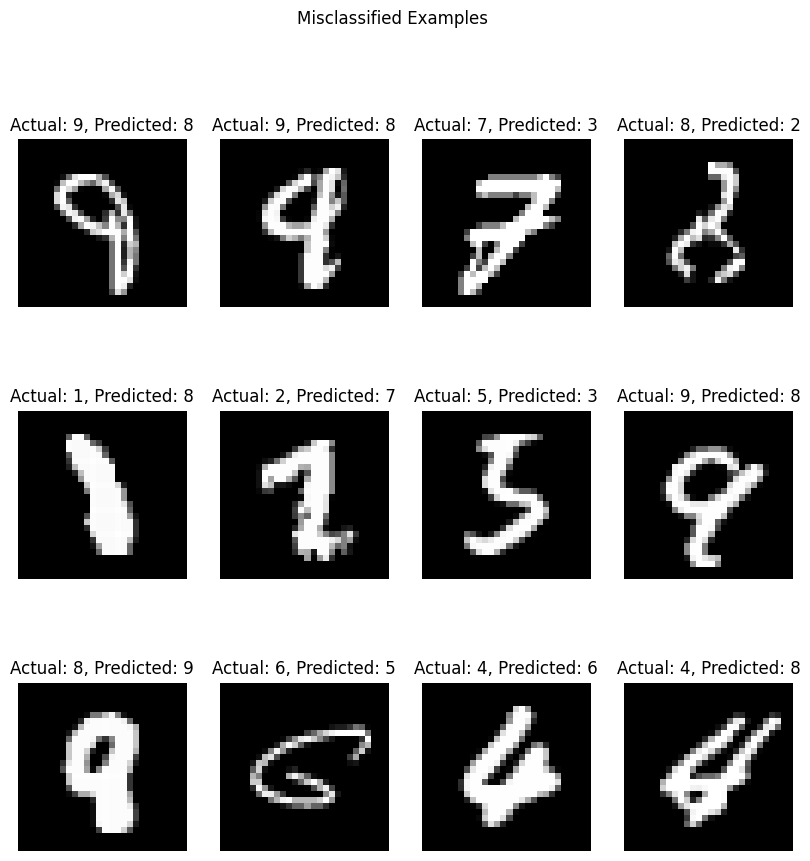

In [26]:
# Show a few misclassified examples
misclassified_indices=np.where(y_pred != y_true)[0]
print(f"Number of misclassified examples: {len(misclassified_indices)}")

def plot_misclassified(indices):
  plt.figure(figsize=(10, 10))
  for i, index in enumerate(indices[:12]):
    plt.subplot(3, 4, i+1)
    plt.imshow(X_test[index], cmap='gray')
    plt.title(f"Actual: {np.argmax(y_test[index])}, Predicted: {y_pred[index]}")
    plt.axis('off')
  plt.suptitle('Misclassified Examples')
  save_path=ARTIFACTS_DIR/'misclassified_examples.png'
  plt.savefig(save_path, dpi=300)
  plt.show()

plot_misclassified(misclassified_indices)

**Insights & Real-World Applications**

1. Model Performance
*   The CNN achieved a test accuracy of 99.30%, which is excellent for the MNIST dataset.
*   The confusion matrix shows the model performs very well across all digits, with minimal misclassifications. Most errors occur between visually similar digits like 4 & 9 or 3 & 5.

2. Practical Applications
* Banking & Finance-Automating cheque processing by recognizing handwritten amounts.

* Postal Services-Reading handwritten postal codes for mail sorting.

* Education-Digitizing handwritten exam papers for automatic grading systems.

* Accessibility-Helping visually impaired users interact with handwritten content via OCR.

3. Key Takeaways
* Data Augmentation (rotation, shift, zoom) improved generalization and reduced overfitting.

* Batch Normalization stabilized training, leading to faster convergence.

* Dropout Layers reduced overfitting by forcing the network to learn robust features.

* The modular project structure (separate scripts for data loading, training, and evaluation) ensures maintainability and scalability.

* The trained CNN model was successfully integrated into a Streamlit application, enabling users to draw digits on a canvas and instantly see predictions.

4. Future Improvements

* Test on more challenging datasets like EMNIST (handwritten letters & digits).

* Experiment with transfer learning from larger handwriting datasets.